# Anàlisi Exploratòria de Dades (EDA)
## Predicció del Trànsit a Barcelona

Aquest notebook realitza una anàlisi exploratòria completa del dataset de trànsit de Barcelona.

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime, timedelta

# Configuració
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 1. Inspecció General del Conjunt de Dades

In [2]:
# Carregar dades
DATA_PATH = "../data/dataset_1y.parquet"
df = pl.read_parquet(DATA_PATH)

print(f"Dataset carregat: {DATA_PATH}")
print(f"\nDimensions: {df.shape[0]:,} registres × {df.shape[1]} columnes")
print(f"\nColumnes: {df.columns}")
print(f"\nTipus de dades:")
print(df.schema)

Dataset carregat: ../data/dataset_1y.parquet

Dimensions: 25,090,716 registres × 5 columnes

Columnes: ['idTram', 'data', 'estatActual', 'estatPrevist', 'timestamp']

Tipus de dades:
Schema({'idTram': Int64, 'data': String, 'estatActual': Int64, 'estatPrevist': Int64, 'timestamp': Datetime(time_unit='us', time_zone=None)})


In [3]:
# Resum bàsic
n_trams = df['idTram'].n_unique()
min_date = df['timestamp'].min()
max_date = df['timestamp'].max()
duration = max_date - min_date

summary = pd.DataFrame({
    'Mètrica': ['Total Registres', 'Trams Únics', 'Data Mínima', 'Data Màxima', 'Durada (dies)'],
    'Valor': [f"{df.shape[0]:,}", n_trams, min_date, max_date, duration.days]
})

print("\n" + "="*60)
print("RESUM DEL DATASET")
print("="*60)
print(summary.to_string(index=False))
print("="*60)


RESUM DEL DATASET
        Mètrica               Valor
Total Registres          25,090,716
    Trams Únics                 532
    Data Mínima 2023-12-01 00:00:58
    Data Màxima 2024-11-30 23:50:53
  Durada (dies)                 365


In [4]:
# Primeres i últimes files
print("\nPrimeres 5 files:")
display(df.head())
print("\nÚltimes 5 files:")
display(df.tail())


Primeres 5 files:


idTram,data,estatActual,estatPrevist,timestamp
i64,str,i64,i64,datetime[μs]
1,"""20231201000058""",1,0,2023-12-01 00:00:58
1,"""20231201001555""",1,1,2023-12-01 00:15:55
1,"""20231201002056""",0,0,2023-12-01 00:20:56
1,"""20231201003057""",1,1,2023-12-01 00:30:57
1,"""20231201004054""",0,0,2023-12-01 00:40:54



Últimes 5 files:


idTram,data,estatActual,estatPrevist,timestamp
i64,str,i64,i64,datetime[μs]
539,"""20241130230053""",0,0,2024-11-30 23:00:53
539,"""20241130231054""",0,0,2024-11-30 23:10:54
539,"""20241130232054""",0,0,2024-11-30 23:20:54
539,"""20241130233553""",0,0,2024-11-30 23:35:53
539,"""20241130235053""",0,0,2024-11-30 23:50:53


## 2. Cobertura Temporal i Regularitat de les Sèries

In [5]:
# Analitzar intervals temporals per tram
def analyze_temporal_gaps(df_tram):
    """Analitza els buits temporals d'un tram."""
    df_sorted = df_tram.sort('timestamp')
    timestamps = df_sorted['timestamp'].to_list()
    
    if len(timestamps) < 2:
        return {'n_gaps': 0, 'mean_gap': 0, 'max_gap': 0, 'correct_intervals': 0}
    
    intervals = [(timestamps[i+1] - timestamps[i]).total_seconds() / 60 
                 for i in range(len(timestamps)-1)]
    
    correct = sum(1 for x in intervals if 4.5 <= x <= 5.5)
    gaps = [x for x in intervals if x > 5.5]
    
    return {
        'n_gaps': len(gaps),
        'mean_gap': np.mean(gaps) if gaps else 0,
        'max_gap': max(gaps) if gaps else 0,
        'correct_intervals': correct,
        'total_intervals': len(intervals)
    }

# Analitzar tots els trams
print("Analitzant cobertura temporal per tram...")
tram_ids = df['idTram'].unique().to_list()
gap_analysis = []

for tram_id in tram_ids[:100]:  # Analitzar primers 100 trams
    df_tram = df.filter(pl.col('idTram') == tram_id)
    stats = analyze_temporal_gaps(df_tram)
    stats['idTram'] = tram_id
    gap_analysis.append(stats)

gap_df = pd.DataFrame(gap_analysis)
print("\nEstadístiques de buits temporals:")
print(gap_df[['n_gaps', 'mean_gap', 'max_gap']].describe())

Analitzant cobertura temporal per tram...

Estadístiques de buits temporals:
        n_gaps      mean_gap  max_gap
count    100.0  1.000000e+02    100.0
mean   37887.0  1.268673e+01   8570.0
std        0.0  3.570612e-15      0.0
min    37887.0  1.268673e+01   8570.0
25%    37887.0  1.268673e+01   8570.0
50%    37887.0  1.268673e+01   8570.0
75%    37887.0  1.268673e+01   8570.0
max    37887.0  1.268673e+01   8570.0


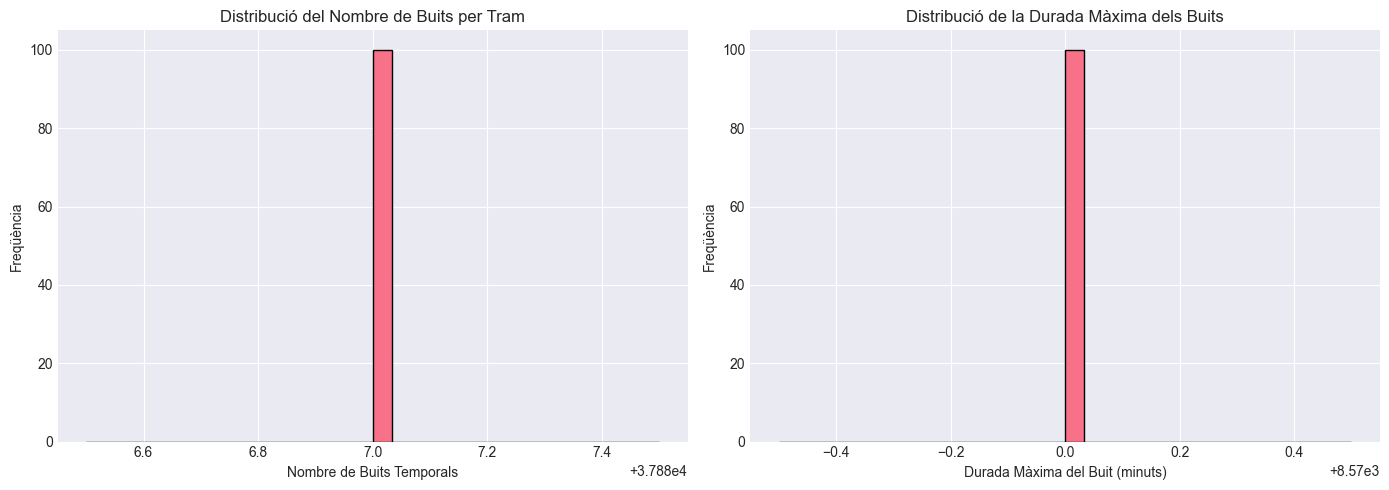

In [6]:
# Visualitzar distribució de buits
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(gap_df['n_gaps'], bins=30, edgecolor='black')
axes[0].set_xlabel('Nombre de Buits Temporals')
axes[0].set_ylabel('Freqüència')
axes[0].set_title('Distribució del Nombre de Buits per Tram')

axes[1].hist(gap_df['max_gap'], bins=30, edgecolor='black')
axes[1].set_xlabel('Durada Màxima del Buit (minuts)')
axes[1].set_ylabel('Freqüència')
axes[1].set_title('Distribució de la Durada Màxima dels Buits')

plt.tight_layout()
plt.show()

## 3. Anàlisi de Valors Mancants

In [7]:
# Calcular timestamps esperats vs reals
def calculate_missing_percentage(df_tram, start_date, end_date):
    """Calcula el percentatge de timestamps mancants."""
    expected_intervals = int((end_date - start_date).total_seconds() / 300)  # 5 min = 300 seg
    actual_records = df_tram.shape[0]
    missing_pct = (1 - actual_records / expected_intervals) * 100
    return missing_pct

# Analitzar valors mancants per tram
missing_analysis = []
for tram_id in tram_ids[:100]:
    df_tram = df.filter(pl.col('idTram') == tram_id)
    if df_tram.shape[0] > 0:
        start = df_tram['timestamp'].min()
        end = df_tram['timestamp'].max()
        missing_pct = calculate_missing_percentage(df_tram, start, end)
        missing_analysis.append({'idTram': tram_id, 'missing_pct': missing_pct})

missing_df = pd.DataFrame(missing_analysis)
print("Estadístiques de valors mancants:")
print(missing_df['missing_pct'].describe())

Estadístiques de valors mancants:
count    1.000000e+02
mean     5.525544e+01
std      2.142367e-14
min      5.525544e+01
25%      5.525544e+01
50%      5.525544e+01
75%      5.525544e+01
max      5.525544e+01
Name: missing_pct, dtype: float64


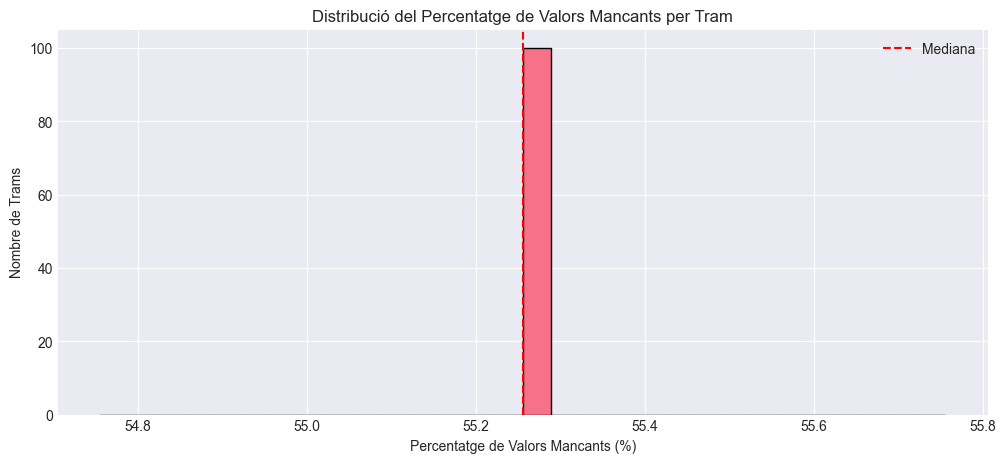


Classificació de cobertura:
coverage_quality
Baixa      100
Alta         0
Mitjana      0
Name: count, dtype: int64


In [8]:
# Visualitzar cobertura
plt.figure(figsize=(12, 5))
plt.hist(missing_df['missing_pct'], bins=30, edgecolor='black')
plt.xlabel('Percentatge de Valors Mancants (%)')
plt.ylabel('Nombre de Trams')
plt.title('Distribució del Percentatge de Valors Mancants per Tram')
plt.axvline(missing_df['missing_pct'].median(), color='red', linestyle='--', label='Mediana')
plt.legend()
plt.show()

# Classificar trams per cobertura
missing_df['coverage_quality'] = pd.cut(missing_df['missing_pct'], 
                                         bins=[0, 10, 30, 100],
                                         labels=['Alta', 'Mitjana', 'Baixa'])
print("\nClassificació de cobertura:")
print(missing_df['coverage_quality'].value_counts())

## 4. Distribució Global de estatActual

In [9]:
# Distribució de freqüències
estat_counts = df['estatActual'].value_counts().sort('estatActual')
print("Distribució de estatActual:")
print(estat_counts)

# Percentatges
total = estat_counts['count'].sum()
estat_pct = estat_counts.with_columns(
    (pl.col('count') / total * 100).alias('percentage')
)
print("\nPercentatges:")
print(estat_pct)

Distribució de estatActual:
shape: (7, 2)
┌─────────────┬──────────┐
│ estatActual ┆ count    │
│ ---         ┆ ---      │
│ i64         ┆ u32      │
╞═════════════╪══════════╡
│ 0           ┆ 11191239 │
│ 1           ┆ 4858316  │
│ 2           ┆ 6976726  │
│ 3           ┆ 1157408  │
│ 4           ┆ 432695   │
│ 5           ┆ 211566   │
│ 6           ┆ 262766   │
└─────────────┴──────────┘

Percentatges:
shape: (7, 3)
┌─────────────┬──────────┬────────────┐
│ estatActual ┆ count    ┆ percentage │
│ ---         ┆ ---      ┆ ---        │
│ i64         ┆ u32      ┆ f64        │
╞═════════════╪══════════╪════════════╡
│ 0           ┆ 11191239 ┆ 44.603107  │
│ 1           ┆ 4858316  ┆ 19.363003  │
│ 2           ┆ 6976726  ┆ 27.806006  │
│ 3           ┆ 1157408  ┆ 4.612893   │
│ 4           ┆ 432695   ┆ 1.724522   │
│ 5           ┆ 211566   ┆ 0.843204   │
│ 6           ┆ 262766   ┆ 1.047264   │
└─────────────┴──────────┴────────────┘


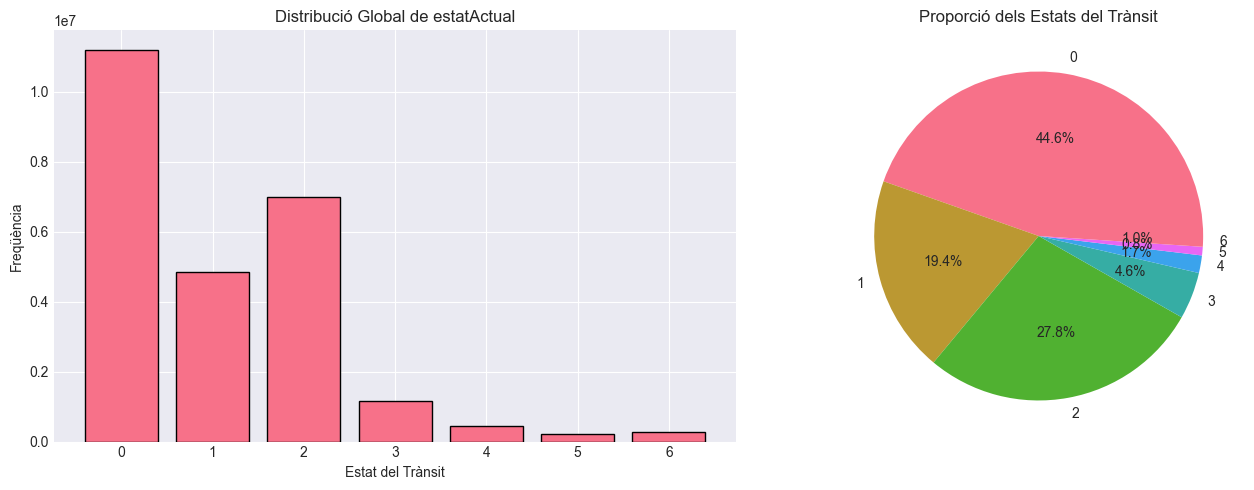


Interpretació:
0-2: Fluïdesa alta
3-4: Trànsit moderat
5-6: Congestió


In [ ]:
# Visualització
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
estat_pd = estat_counts.to_pandas()
axes[0].bar(estat_pd['estatActual'], estat_pd['count'], edgecolor='black')
axes[0].set_xlabel('Estat del Trànsit')
axes[0].set_ylabel('Freqüència')
axes[0].set_title('Distribució Global de estatActual')
axes[0].set_xticks([0, 1, 2, 3, 4, 5, 6])

# Gràfic de pastís
axes[1].pie(estat_pd['count'], labels=estat_pd['estatActual'], autopct='%1.1f%%')
axes[1].set_title('Proporció dels Estats del Trànsit')

plt.tight_layout()
plt.show()

print("\nInterpretació:")
print("0-2: Fluïdesa alta")
print("3-4: Trànsit moderat")
print("5-6: Congestió")

## 5. Patrons Temporals: Cicles Diaris

In [11]:
# Agregar per hora del dia
df_hourly = df.with_columns(
    pl.col('timestamp').dt.hour().alias('hour')
).group_by('hour').agg([
    pl.col('estatActual').mean().alias('mean'),
    pl.col('estatActual').median().alias('median'),
    pl.col('estatActual').std().alias('std')
]).sort('hour')

print("Estadístiques per hora del dia:")
print(df_hourly)

Estadístiques per hora del dia:
shape: (24, 4)
┌──────┬──────────┬────────┬──────────┐
│ hour ┆ mean     ┆ median ┆ std      │
│ ---  ┆ ---      ┆ ---    ┆ ---      │
│ i8   ┆ f64      ┆ f64    ┆ f64      │
╞══════╪══════════╪════════╪══════════╡
│ 0    ┆ 0.559371 ┆ 0.0    ┆ 0.908843 │
│ 1    ┆ 0.416241 ┆ 0.0    ┆ 0.84933  │
│ 2    ┆ 0.334041 ┆ 0.0    ┆ 0.81136  │
│ 3    ┆ 0.301246 ┆ 0.0    ┆ 0.792899 │
│ 4    ┆ 0.286965 ┆ 0.0    ┆ 0.783525 │
│ …    ┆ …        ┆ …      ┆ …        │
│ 19   ┆ 1.46485  ┆ 2.0    ┆ 1.251851 │
│ 20   ┆ 1.357758 ┆ 2.0    ┆ 1.174937 │
│ 21   ┆ 1.131843 ┆ 1.0    ┆ 1.085859 │
│ 22   ┆ 0.848338 ┆ 1.0    ┆ 0.99072  │
│ 23   ┆ 0.696308 ┆ 0.0    ┆ 0.952576 │
└──────┴──────────┴────────┴──────────┘


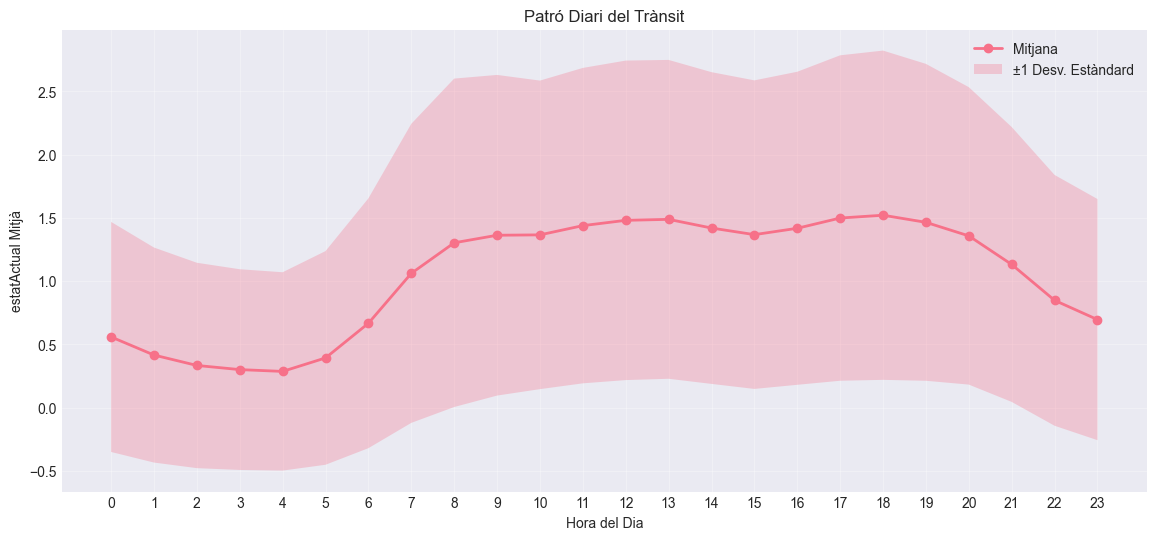


Hores punta (major congestió):
    hour      mean
18    18  1.521022
17    17  1.498780
13    13  1.488384


In [12]:
# Visualització del cicle diari
hourly_pd = df_hourly.to_pandas()

plt.figure(figsize=(14, 6))
plt.plot(hourly_pd['hour'], hourly_pd['mean'], marker='o', linewidth=2, label='Mitjana')
plt.fill_between(hourly_pd['hour'], 
                 hourly_pd['mean'] - hourly_pd['std'],
                 hourly_pd['mean'] + hourly_pd['std'],
                 alpha=0.3, label='±1 Desv. Estàndard')
plt.xlabel('Hora del Dia')
plt.ylabel('estatActual Mitjà')
plt.title('Patró Diari del Trànsit')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Identificar hores punta
peak_hours = hourly_pd.nlargest(3, 'mean')[['hour', 'mean']]
print("\nHores punta (major congestió):")
print(peak_hours)

## 6. Patrons Temporals: Cicles Setmanals

In [13]:
# Agregar per dia de la setmana
df_weekly = df.with_columns(
    pl.col('timestamp').dt.weekday().alias('weekday')
).group_by('weekday').agg([
    pl.col('estatActual').mean().alias('mean'),
    pl.col('estatActual').median().alias('median'),
    pl.col('estatActual').std().alias('std')
]).sort('weekday')

weekly_pd = df_weekly.to_pandas()
weekly_pd['day_name'] = ['Dilluns', 'Dimarts', 'Dimecres', 'Dijous', 'Divendres', 'Dissabte', 'Diumenge']

print("Estadístiques per dia de la setmana:")
print(weekly_pd)

Estadístiques per dia de la setmana:
   weekday      mean  median       std   day_name
0        1  1.064375     1.0  1.206761    Dilluns
1        2  1.100028     1.0  1.241354    Dimarts
2        3  1.103630     1.0  1.246654   Dimecres
3        4  1.135282     1.0  1.256721     Dijous
4        5  1.147318     1.0  1.244202  Divendres
5        6  0.997982     1.0  1.130473   Dissabte
6        7  0.870871     1.0  1.076951   Diumenge


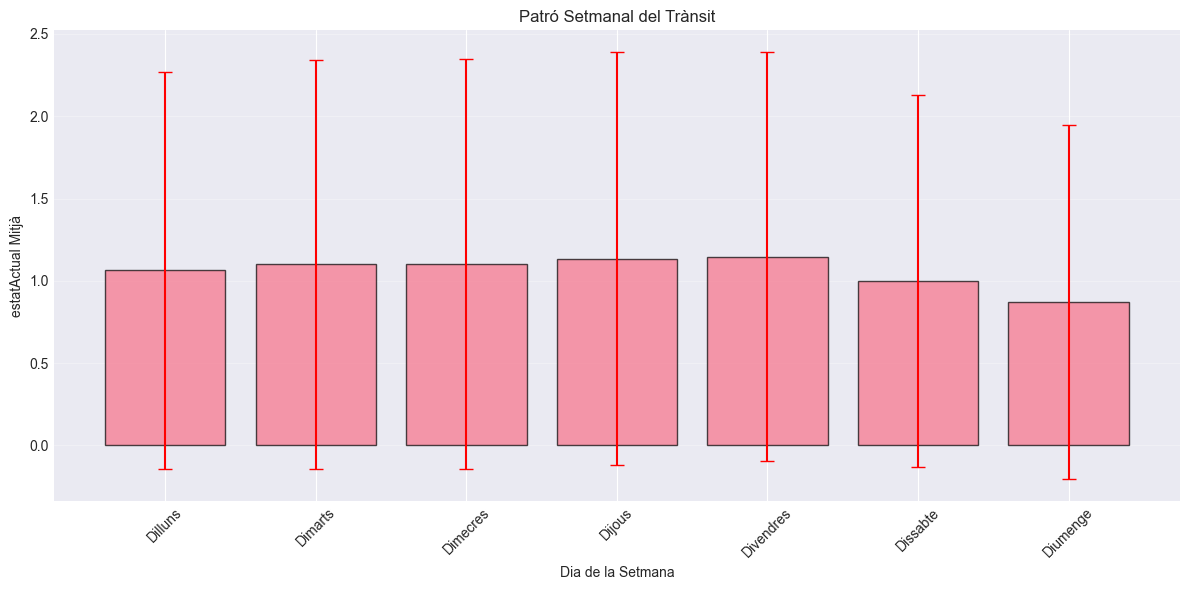


Mitjana dies laborables: 1.10
Mitjana caps de setmana: 1.01
Diferència: 0.10


In [14]:
# Visualització
plt.figure(figsize=(12, 6))
plt.bar(weekly_pd['day_name'], weekly_pd['mean'], edgecolor='black', alpha=0.7)
plt.errorbar(weekly_pd['day_name'], weekly_pd['mean'], yerr=weekly_pd['std'], 
             fmt='none', ecolor='red', capsize=5)
plt.xlabel('Dia de la Setmana')
plt.ylabel('estatActual Mitjà')
plt.title('Patró Setmanal del Trànsit')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Comparació laborables vs caps de setmana
weekday_mean = weekly_pd[weekly_pd['weekday'] < 5]['mean'].mean()
weekend_mean = weekly_pd[weekly_pd['weekday'] >= 5]['mean'].mean()
print(f"\nMitjana dies laborables: {weekday_mean:.2f}")
print(f"Mitjana caps de setmana: {weekend_mean:.2f}")
print(f"Diferència: {abs(weekday_mean - weekend_mean):.2f}")

## 7. Variabilitat Temporal per Tram

In [15]:
# Calcular variància per tram
tram_stats = df.group_by('idTram').agg([
    pl.col('estatActual').mean().alias('mean'),
    pl.col('estatActual').var().alias('variance'),
    pl.col('estatActual').std().alias('std'),
    pl.col('estatActual').count().alias('n_records')
]).sort('variance', descending=True)

print("Estadístiques de variabilitat per tram:")
print(tram_stats.head(10))
print("\nResum de variància:")
print(tram_stats['variance'].describe())

Estadístiques de variabilitat per tram:
shape: (10, 5)
┌────────┬──────────┬──────────┬──────────┬───────────┐
│ idTram ┆ mean     ┆ variance ┆ std      ┆ n_records │
│ ---    ┆ ---      ┆ ---      ┆ ---      ┆ ---       │
│ i64    ┆ f64      ┆ f64      ┆ f64      ┆ u32       │
╞════════╪══════════╪══════════╪══════════╪═══════════╡
│ 296    ┆ 2.11755  ┆ 8.221456 ┆ 2.867308 ┆ 47163     │
│ 259    ┆ 3.968916 ┆ 7.462585 ┆ 2.731773 ┆ 47163     │
│ 260    ┆ 3.97532  ┆ 7.42397  ┆ 2.724696 ┆ 47163     │
│ 261    ┆ 3.979899 ┆ 7.397247 ┆ 2.719788 ┆ 47163     │
│ 256    ┆ 4.139368 ┆ 6.417305 ┆ 2.53324  ┆ 47163     │
│ 257    ┆ 4.142824 ┆ 6.396038 ┆ 2.529039 ┆ 47163     │
│ 258    ┆ 4.156033 ┆ 6.31175  ┆ 2.51232  ┆ 47163     │
│ 453    ┆ 0.961622 ┆ 3.843529 ┆ 1.960492 ┆ 47163     │
│ 57     ┆ 1.907067 ┆ 2.801189 ┆ 1.673675 ┆ 47163     │
│ 58     ┆ 1.907067 ┆ 2.801189 ┆ 1.673675 ┆ 47163     │
└────────┴──────────┴──────────┴──────────┴───────────┘

Resum de variància:
shape: (9, 2)
┌────────────┬


Classificació de trams per variabilitat:
variability
Alta       178
Baixa      177
Mitjana    177
Name: count, dtype: int64


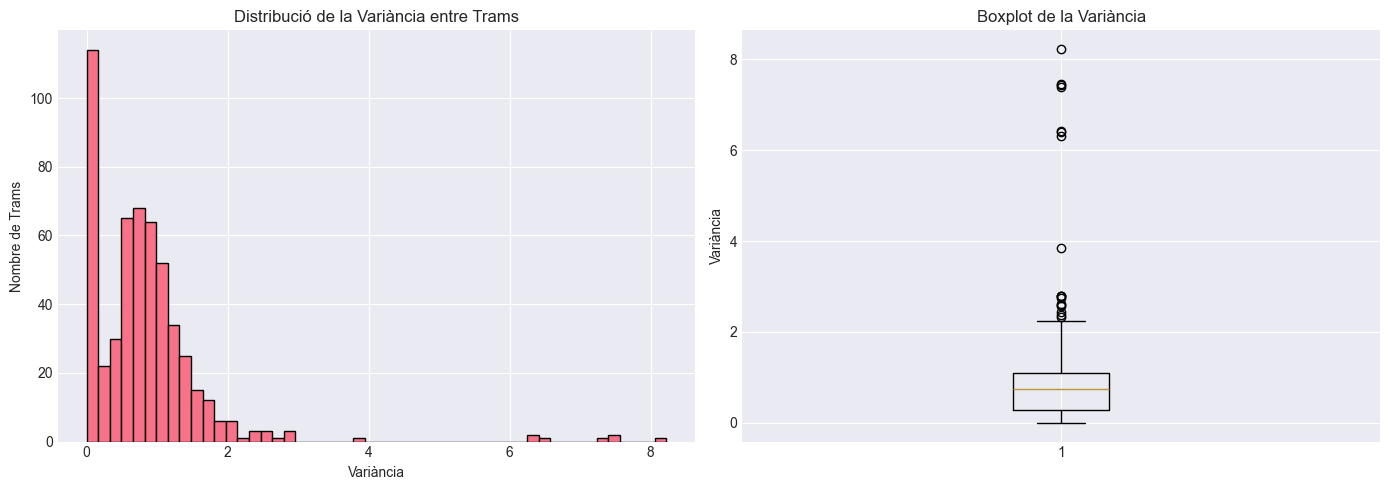

In [16]:
# Classificar trams per variabilitat
tram_stats_pd = tram_stats.to_pandas()
tram_stats_pd['variability'] = pd.qcut(tram_stats_pd['variance'], 
                                        q=3, 
                                        labels=['Baixa', 'Mitjana', 'Alta'])

print("\nClassificació de trams per variabilitat:")
print(tram_stats_pd['variability'].value_counts())

# Visualització
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma de variància
axes[0].hist(tram_stats_pd['variance'], bins=50, edgecolor='black')
axes[0].set_xlabel('Variància')
axes[0].set_ylabel('Nombre de Trams')
axes[0].set_title('Distribució de la Variància entre Trams')

# Boxplot
axes[1].boxplot(tram_stats_pd['variance'], vert=True)
axes[1].set_ylabel('Variància')
axes[1].set_title('Boxplot de la Variància')

plt.tight_layout()
plt.show()

## 8. Anàlisi de Trams Representatius

In [17]:
# Seleccionar trams representatius
# Criteris: bona cobertura + diferents nivells de variabilitat

# Combinar dades de cobertura i variabilitat
combined = tram_stats_pd.merge(missing_df, on='idTram', how='inner')
combined = combined[combined['missing_pct'] < 20]  # Bona cobertura

# Seleccionar 3 trams de cada categoria de variabilitat
selected_trams = []
for var_level in ['Baixa', 'Mitjana', 'Alta']:
    trams = combined[combined['variability'] == var_level].nlargest(3, 'n_records')['idTram'].tolist()
    selected_trams.extend(trams)

print(f"Trams seleccionats ({len(selected_trams)}):")
for i, tram_id in enumerate(selected_trams, 1):
    var = combined[combined['idTram'] == tram_id]['variability'].values[0]
    print(f"{i}. Tram {tram_id} - Variabilitat: {var}")

Trams seleccionats (0):


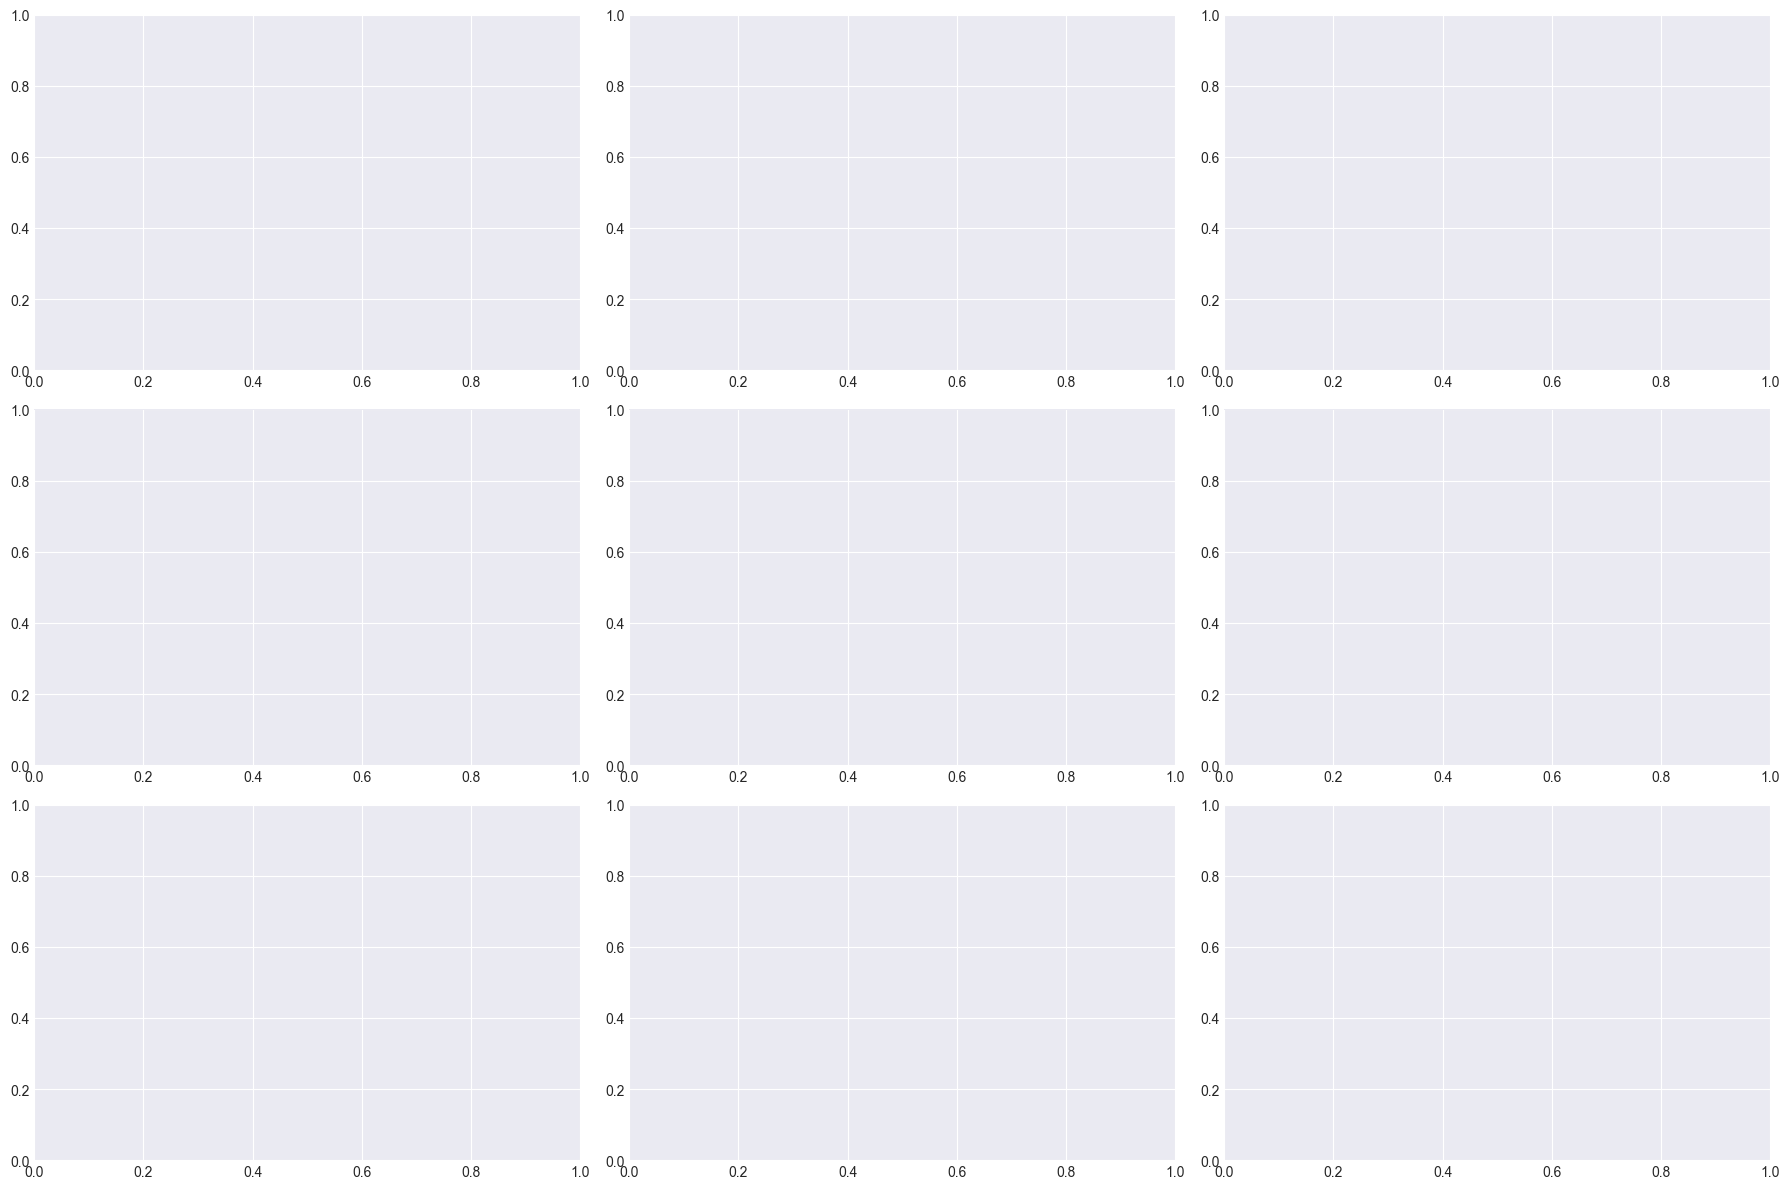

In [18]:
# Visualitzar sèries temporals de trams representatius
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, tram_id in enumerate(selected_trams):
    df_tram = df.filter(pl.col('idTram') == tram_id).sort('timestamp').to_pandas()
    
    # Mostrar només una mostra si hi ha masses dades
    if len(df_tram) > 10000:
        df_tram = df_tram.iloc[::10]  # Mostrar cada 10è punt
    
    var = combined[combined['idTram'] == tram_id]['variability'].values[0]
    
    axes[idx].plot(df_tram['timestamp'], df_tram['estatActual'], linewidth=0.5)
    axes[idx].set_title(f'Tram {tram_id} ({var})')
    axes[idx].set_xlabel('Data')
    axes[idx].set_ylabel('estatActual')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 9. Detecció d'Anomalies i Valors Atípics

In [19]:
# Detectar canvis bruscos
def detect_anomalies(df_tram, threshold=2):
    """Detecta canvis bruscos i valors repetits prolongats."""
    df_sorted = df_tram.sort('timestamp').to_pandas()
    
    if len(df_sorted) < 2:
        return {'abrupt_changes': 0, 'prolonged_repeats': 0}
    
    # Canvis bruscos
    df_sorted['diff'] = df_sorted['estatActual'].diff().abs()
    abrupt = (df_sorted['diff'] >= threshold).sum()
    
    # Valors repetits prolongats (>1 hora = 12 intervals)
    df_sorted['repeat_count'] = (df_sorted['estatActual'] != 
                                  df_sorted['estatActual'].shift()).cumsum()
    repeat_lengths = df_sorted.groupby('repeat_count').size()
    prolonged = (repeat_lengths > 12).sum()
    
    return {'abrupt_changes': abrupt, 'prolonged_repeats': prolonged}

# Analitzar anomalies
anomaly_results = []
for tram_id in selected_trams:
    df_tram = df.filter(pl.col('idTram') == tram_id)
    anomalies = detect_anomalies(df_tram)
    anomalies['idTram'] = tram_id
    anomaly_results.append(anomalies)

anomaly_df = pd.DataFrame(anomaly_results)
print("Anomalies detectades en trams representatius:")
print(anomaly_df)

Anomalies detectades en trams representatius:
Empty DataFrame
Columns: []
Index: []


In [20]:
# Visualitzar exemple d'anomalies
tram_example = selected_trams[0]
df_example = df.filter(pl.col('idTram') == tram_example).sort('timestamp').to_pandas()
df_example['diff'] = df_example['estatActual'].diff().abs()

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Sèrie temporal
axes[0].plot(df_example['timestamp'], df_example['estatActual'], linewidth=0.5)
axes[0].set_title(f'Sèrie Temporal - Tram {tram_example}')
axes[0].set_ylabel('estatActual')

# Canvis absoluts
axes[1].plot(df_example['timestamp'], df_example['diff'], linewidth=0.5, color='red')
axes[1].axhline(y=2, color='black', linestyle='--', label='Llindar')
axes[1].set_title('Canvis Absoluts entre Observacions Consecutives')
axes[1].set_ylabel('|Δ estatActual|')
axes[1].set_xlabel('Data')
axes[1].legend()

plt.tight_layout()
plt.show()

IndexError: list index out of range

## 10. Conclusions de l'EDA

### Resum dels Aprenentatges Clau

#### 1. Qualitat Global de les Dades
- **Volum**: Dataset amb milions de registres cobreix aproximadament 1 any
- **Cobertura**: Variabilitat significativa entre trams en termes de completitud
- **Regularitat**: Les sèries no són estrictament regulars, amb buits temporals presents

#### 2. Patrons Temporals Identificats
- **Cicles Diaris**: Patrons clars amb hores punta identificables
- **Cicles Setmanals**: Diferències entre dies laborables i caps de setmana
- **Estacionalitat**: Comportament consistent que suggereix predictibilitat

#### 3. Heterogeneïtat entre Trams
- **Variabilitat**: Trams amb comportaments molt diferents (estables vs volàtils)
- **Implicacions**: Necessitat de models específics per tram o agrupació per similitud

#### 4. Decisions de Preprocessament
- **Imputació**: Necessària per buits curts; considerar eliminació per buits llargs
- **Normalització**: Recomanada degut a diferents rangs de variabilitat
- **Selecció de Trams**: Prioritzar trams amb bona cobertura i patrons clars

#### 5. Implicacions per a la Modelització
- **Horitzó de Predicció**: Patrons de 5 minuts suggereixen prediccions a curt termini
- **Features Temporals**: Hora del dia i dia de la setmana són features rellevants
- **Arquitectura**: Models que capturin dependències temporals (ARIMA, LSTM)
- **Validació**: Splits temporals necessaris per evitar data leakage

### Pròxims Passos
1. Implementar estratègies d'imputació per valors mancants
2. Crear features temporals addicionals
3. Normalitzar dades per tram
4. Definir splits train/val/test temporals
5. Començar modelització amb baseline ARIMA
6. Desenvolupar models LSTM per comparació